In [86]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib notebook

In [62]:
games_df = pd.read_csv("../Resources/vgsales.csv.zip")
ratings_df = pd.read_csv("../Resources/metacritic_games.csv")

<IPython.core.display.Javascript object>


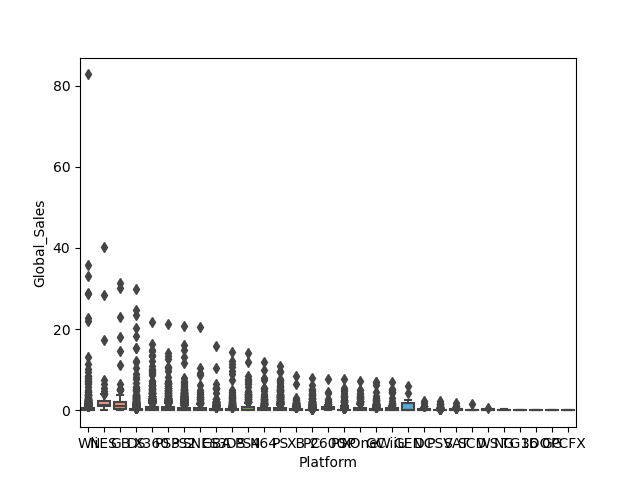

In [63]:
sns.boxplot(data=games_df, x="Platform", y="Global_Sales")

In [64]:
ratings_df.rename({"game":"Name"},axis=1, inplace=True)

In [65]:
ratings_df

,Name,platform,developer,genre,number_players,rating,release_date,positive_critics,neutral_critics,negative_critics,positive_users,neutral_users,negative_users,metascore,user_score
0,Portal 2,PC,Valve Software,Action,NaN,E10+,"Apr 18, 2011",51,1,0,1700,107,19,95,90
1,The Elder Scrolls V: Skyrim,PC,Bethesda Game Studios,Role-Playing,No Online Multiplayer,M,"Nov 10, 2011",32,0,0,1616,322,451,94,82
2,The Legend of Zelda: Ocarina of Time 3D,3DS,GREZZO,Miscellaneous,No Online Multiplayer,E10+,"Jun 19, 2011",84,1,0,283,20,5,94,90
3,Batman: Arkham City,PC,Rocksteady Studios,Action Adventure,NaN,T,"Nov 21, 2011",27,0,0,240,34,27,91,87
4,Super Mario 3D Land,3DS,Nintendo,Action,No Online Multiplayer,E,"Nov 13, 2011",81,1,0,251,39,11,90,84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5694,Modern Combat: Blackout,Switch,Gameloft,Action,No Online Multiplayer,NaN,"Feb 14, 2019",0,5,2,1,0,1,53,57
5695,Fimbul,PS4,Zaxis,Action Adventure,No Online Multiplayer,NaN,"Feb 28, 2019",0,7,2,1,0,0,52,18
5696,Generation Zero,PC,Avalanche Studios,Action Adventure,Online Multiplayer,T,"Mar 26, 2019",1,11,6,5,2,6,50,57
5697,Vane,PS4,Friend & Foe,Adventure,No Online Multiplayer,E10+,"Jan 15, 2019",3,26,22,2,2,2,49,55


In [67]:
games_df.loc[games_df["Name"]=="Grand Theft Auto V"]

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
16,17,Grand Theft Auto V,PS3,2013.0,Action,Take-Two Interactive,7.01,9.27,0.97,4.14,21.40
23,24,Grand Theft Auto V,X360,2013.0,Action,Take-Two Interactive,9.63,5.31,0.06,1.38,16.38
44,45,Grand Theft Auto V,PS4,2014.0,Action,Take-Two Interactive,3.80,5.81,0.36,2.02,11.98
197,198,Grand Theft Auto V,XOne,2014.0,Action,Take-Two Interactive,2.66,2.01,0.00,0.41,5.08
1896,1898,Grand Theft Auto V,PC,2015.0,Action,Take-Two Interactive,0.36,0.64,0.00,0.08,1.08


In [70]:
new_df = pd.merge(games_df, ratings_df, how="left", left_on=["Name","Platform"], right_on=["Name", "platform"])
new_df

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,...,rating,release_date,positive_critics,neutral_critics,negative_critics,positive_users,neutral_users,negative_users,metascore,user_score
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16593,16596,Woody Woodpecker in Crazy Castle 5,GBA,2002.0,Platform,Kemco,0.01,0.00,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16594,16597,Men in Black II: Alien Escape,GC,2003.0,Shooter,Infogrames,0.01,0.00,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16595,16598,SCORE International Baja 1000: The Official Game,PS2,2008.0,Racing,Activision,0.00,0.00,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16596,16599,Know How 2,DS,2010.0,Puzzle,7G//AMES,0.00,0.01,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [92]:
new_df.columns.tolist()

['Rank',
 'Name',
 'Platform',
 'Year',
 'Genre',
 'Publisher',
 'NA_Sales',
 'EU_Sales',
 'JP_Sales',
 'Other_Sales',
 'Global_Sales',
 'platform',
 'developer',
 'genre',
 'number_players',
 'rating',
 'release_date',
 'positive_critics',
 'neutral_critics',
 'negative_critics',
 'positive_users',
 'neutral_users',
 'negative_users',
 'metascore',
 'user_score']

In [91]:
# Gather all games for each platform that there is no rating data for.
no_rating_df = new_df.loc[new_df["release_date"].isnull()]
no_rating_df.to_csv("../Resources/games_to_get_ratings.csv")


In [21]:
new_df[new_df["Name"]=="Grand Theft Auto V"]

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,...,rating,release_date,positive_critics,neutral_critics,negative_critics,positive_users,neutral_users,negative_users,metascore,user_score
1,45,Grand Theft Auto V,PS4,2014.0,Action,Take-Two Interactive,3.80,5.81,0.36,2.02,...,M,"Nov 18, 2014",66,0,0,369,71,69,97,83
89,1898,Grand Theft Auto V,PC,2015.0,Action,Take-Two Interactive,0.36,0.64,0.00,0.08,...,M,"Apr 14, 2015",56,1,0,407,108,250,96,77


In [22]:
all_consoles_games_df = games_df.groupby("Name").sum().drop(["Rank","Year"],axis=1).sort_values("Global_Sales", ascending=False)

In [23]:
all_consoles_games_df

,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
Name,,,,,
Wii Sports,41.49,29.02,3.77,8.46,82.74
Grand Theft Auto V,23.46,23.04,1.39,8.03,55.92
Super Mario Bros.,32.48,4.88,6.96,0.99,45.31
Tetris,26.17,2.95,6.03,0.69,35.84
Mario Kart Wii,15.85,12.88,3.79,3.31,35.82
...,...,...,...,...,...
WinBack 2: Project Poseidon,0.01,0.01,0.00,0.00,0.01
Super Robot Taisen XO,0.00,0.00,0.01,0.00,0.01
Dragon Quest X: All in One Package,0.00,0.00,0.01,0.00,0.01


In [24]:
sales_by_platform = games_df.groupby("Platform").sum().drop(["Rank","Year"],axis=1).sort_values("Global_Sales",ascending=False)

In [25]:
# Should we include all the platforms, or only more recent ones since we will be trying
# to predict sales on only the most recent consoles and the market has changed quite a bit.
# For example, the growth of the digital sales market.
sales_by_platform

,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
Platform,,,,,
PS2,583.84,339.29,139.20,193.44,1255.64
X360,601.05,280.58,12.43,85.54,979.96
PS3,392.26,343.71,79.99,141.93,957.84
Wii,507.71,268.38,69.35,80.61,926.71
DS,390.71,194.65,175.57,60.53,822.49
PS,336.51,213.60,139.82,40.91,730.66
GBA,187.54,75.25,47.33,7.73,318.50
PSP,108.99,68.25,76.79,42.19,296.28
PS4,96.80,123.70,14.30,43.36,278.10


In [26]:
# Create handheld column
handheld_platforms = ["WS", "PSV", "3DS", "GB", "PSP", "GBA", "DS", "GG", "SCD","PSV"]
at_home_platforms = ["PCFX", "3DO","TG16", "DC", "SAT", "WiiU", "2600", "XOne","GC", "SNES", "N64",
                    "NES", "XB", "PC", "PS4","PS", "Wii", "PS3","X360","PS2", "GEN","NG",]

In [27]:
# Create deprecated console column. "No longer in production"
# Suspect, should not be in deprecated_consoles list: ["PSV", "3DS", "Wii",]
# "GG" is for "Sega Game Gear", "NG" is for "Neo Geo" arcades, "SCD" is for 
# "Nintendo Suplemental Computing Device" and "GEN" is for "Sega Genesis"
# I Placed NG in the deprecated consoles list because arcade games are not relevant to how we will use the data. Will consider deleting it entirely.
deprecated_consoles = ["PCFX", "3DO","TG16","WS", "DC", "SAT", "PSV", "2600","GC", "SNES", "N64", "3DS",
                      "NES","GB","XB", "PSP", "GBA","PS", "DS", "Wii","PS3","X360","PS2", "GEN", "NG","GG"]



In [29]:
games_df.loc[games_df["Platform"]=="GEN"]

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
143,144,Sonic the Hedgehog 2,GEN,1992.0,Platform,Sega,4.47,1.20,0.16,0.19,6.03
254,255,Sonic the Hedgehog,GEN,1991.0,Platform,Sega,3.03,0.91,0.26,0.13,4.34
564,565,Mortal Kombat,GEN,1992.0,Fighting,Arena Entertainment,1.95,0.63,0.00,0.09,2.67
588,589,Streets of Rage,GEN,1990.0,Action,Sega,1.86,0.55,0.11,0.08,2.60
827,829,NBA Jam,GEN,1992.0,Sports,Arena Entertainment,1.75,0.25,0.00,0.05,2.05
952,954,Sonic & Knuckles,GEN,1994.0,Platform,Sega,1.24,0.43,0.03,0.12,1.82
991,993,Sonic the Hedgehog 3,GEN,1994.0,Platform,Sega,1.02,0.47,0.20,0.07,1.76
1099,1101,Street Fighter II': Special Champion Edition,GEN,1992.0,Fighting,Sega,1.00,0.30,0.31,0.04,1.66
1372,1374,Disney's The Lion King,GEN,1994.0,Platform,Virgin Interactive,0.97,0.37,0.03,0.05,1.41
1458,1460,Mortal Kombat 3,GEN,1994.0,Fighting,Acclaim Entertainment,1.03,0.27,0.00,0.04,1.34


In [30]:
# creating a column for whether the game was handheld or not 
games_df["is_handheld"] = games_df["Platform"].apply(lambda x: "yes" if x in handheld_platforms else "no")

In [31]:
games_df

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,is_handheld
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74,no
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,no
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82,no
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00,no
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,yes
...,...,...,...,...,...,...,...,...,...,...,...,...
16593,16596,Woody Woodpecker in Crazy Castle 5,GBA,2002.0,Platform,Kemco,0.01,0.00,0.00,0.00,0.01,yes
16594,16597,Men in Black II: Alien Escape,GC,2003.0,Shooter,Infogrames,0.01,0.00,0.00,0.00,0.01,no
16595,16598,SCORE International Baja 1000: The Official Game,PS2,2008.0,Racing,Activision,0.00,0.00,0.00,0.00,0.01,no
16596,16599,Know How 2,DS,2010.0,Puzzle,7G//AMES,0.00,0.01,0.00,0.00,0.01,yes


In [32]:
# creating a column for whether the game is deprecated or not
games_df["is_deprecated"] = games_df["Platform"].apply(lambda x: "yes" if x in deprecated_consoles else "no")

In [59]:
games_df

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,is_handheld,is_deprecated
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74,no,yes
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,no,yes
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82,no,yes
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00,no,yes
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,yes,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16593,16596,Woody Woodpecker in Crazy Castle 5,GBA,2002.0,Platform,Kemco,0.01,0.00,0.00,0.00,0.01,yes,yes
16594,16597,Men in Black II: Alien Escape,GC,2003.0,Shooter,Infogrames,0.01,0.00,0.00,0.00,0.01,no,yes
16595,16598,SCORE International Baja 1000: The Official Game,PS2,2008.0,Racing,Activision,0.00,0.00,0.00,0.00,0.01,no,yes
16596,16599,Know How 2,DS,2010.0,Puzzle,7G//AMES,0.00,0.01,0.00,0.00,0.01,yes,yes
